<a href="https://colab.research.google.com/github/GiulioCMSanto/HDSIdent/blob/master/notebooks/SISO%20Systems/Potential%20Intervals/siso_pettitt_change_point.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SISO Potential Intervals: Non-Parametric Top-Down Pettitt Change-point Method

[HDSIdent: Historical Data Segmentation for System Identification](https://github.com/GiulioCMSanto/HDSIdent)

This notebook explores how to obtain potential intervals for system identification through a non-parametric top-down change-point detection method, considering Single-Input Single-Output systems.

**How to reference this work?**

[SANTO, G. C. M. Data Mining Techniques Applied to Historical Data of Industrial Processes 
as a Tool to Find Time Intervals Suitable for System Identification. Masters dissertation 
– Polytechnic School of the University of São Paulo, São Paulo, Brasil, 2020. 
DOI: 10.13140/RG.2.2.13295.46240](https://www.researchgate.net/publication/347511108_Data_Mining_Techniques_Applied_to_Historical_Data_of_Industrial_Processes_as_a_Tool_to_Find_Time_Intervals_Suitable_for_System_Identification?channel=doi&linkId=5fdf5293a6fdccdcb8e856c4&showFulltext=true)

**About the Method**

The top-down non-parametric change-point method here presented is proposed in 
(WANG et al., 2018 apud PETTITT, 1979):

```
WANG, J. et al. Searching historical data segments for process identification
in feedback control loops. Computers and Chemical Engineering, v. 112, n. 6, p. 6–16, 2018.

PETTITT, A. N. A. A non-parametric approach to the change-point problem.
Journal of the Royal Statistical Society, v. 28, n. 2, p. 126–135, 1979.
```

**About the [Dataset](https://github.com/GiulioCMSanto/HDSIdent/tree/master/data/water_tank)**

The dataset here adopted was produced through simulation in the dissertation (SANTO, G. C. M., 2020). The dataset is created based on the work in (WANG et al., 2018). The transfer functions adopted in the simulation were directly extracted from (WANG et al., 2018 apud YU et al., 2011), as well as the simulation idea, where similar signals were produced.

**References**:

```
SANTO, G. C. M. Data Mining Techniques Applied to Historical Data of Industrial Processes 
as a Tool to Find Time Intervals Suitable for System Identification. Masters dissertation 
– Polytechnic School of the University of São Paulo, São Paulo, Brasil, 2020. 
DOI: 10.13140/RG.2.2.13295.46240.

WANG, J. et al. Searching historical data segments for process identification
in feedback control loops. Computers and Chemical Engineering, v. 112, n. 6, p. 6–16, 2018.

YU, Z. et al. Performance assessment of pid control loops subject to setpoint
changes. Journal of Process Control, v. 21, n. 8, p. 1164–1171, 2011.
````

In [ ]:
!git clone https://github.com/GiulioCMSanto/HDSIdent.git

Cloning into 'HDSIdent'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 602 (delta 37), reused 93 (delta 30), pack-reused 491
Receiving objects: 100% (602/602), 3.80 MiB | 22.75 MiB/s, done.
Resolving deltas: 100% (269/269), done.


In [ ]:
# Change into the directory for install
%cd HDSIdent/

/content/HDSIdent


In [ ]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating HDSIdent.egg-info
writing HDSIdent.egg-info/PKG-INFO
writing dependency_links to HDSIdent.egg-info/dependency_links.txt
writing requirements to HDSIdent.egg-info/requires.txt
writing top-level names to HDSIdent.egg-info/top_level.txt
writing manifest file 'HDSIdent.egg-info/SOURCES.txt'
writing manifest file 'HDSIdent.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/HDSIdent
copying HDSIdent/__init__.py -> build/lib/HDSIdent
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/HDSIdent
copying build/lib/HDSIdent/__init__.py -> build/bdist.linux-x86_64/egg/HDSIdent
byte-compiling build/bdist.linux-x86_64/egg/HDSIdent/__init__.py to __init__.cpython-36.pyc
creating build/bdist.linux-x86_64/egg/EGG-INFO
copying HDSIdent.egg-info/PKG-INFO -> build/bdist.linu

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

import plotly
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode

plotly.io.renderers.default = 'colab'

%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
from HDSIdent.data_treatment.data_preprocessing import Preprocessing
from HDSIdent.initial_intervals.non_parametric_pettitt import PettittMethod

## **1. Read Data**

In [ ]:
mv_url = 'https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/water_tank/siso_simu_mv.csv'
sp_url = 'https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/water_tank/siso_simu_sp.csv'
y_url = 'https://raw.githubusercontent.com/GiulioCMSanto/HDSIdent/master/data/water_tank/siso_simu_y.csv'

In [ ]:
mv = pd.read_csv(mv_url, error_bad_lines=False, header=None)
sp = pd.read_csv(sp_url, error_bad_lines=False, header=None)
y = pd.read_csv(y_url, error_bad_lines=False, header=None)

## **2. Data Preprocessing**

In [ ]:
pp = Preprocessing(
        scaler='MinMaxScaler',
        feature_range=(-0.5,0.5),
        k=100);

In [ ]:
X_clean, Y_clean = pp.fit_transform(X=np.concatenate([mv,sp],axis=1),
                                    y=y)

In [ ]:
df = pd.DataFrame()
df['U'] = X_clean[:,0]
df['SP'] = X_clean[:,1]
df['Y'] = Y_clean

In [ ]:
df.head()

,U,SP,Y
0,0.003182,-0.1,-0.109338
1,-0.000913,-0.1,-0.106037
2,-0.009513,-0.1,-0.099186
3,-0.012116,-0.1,-0.097125
4,-0.008668,-0.1,-0.099873


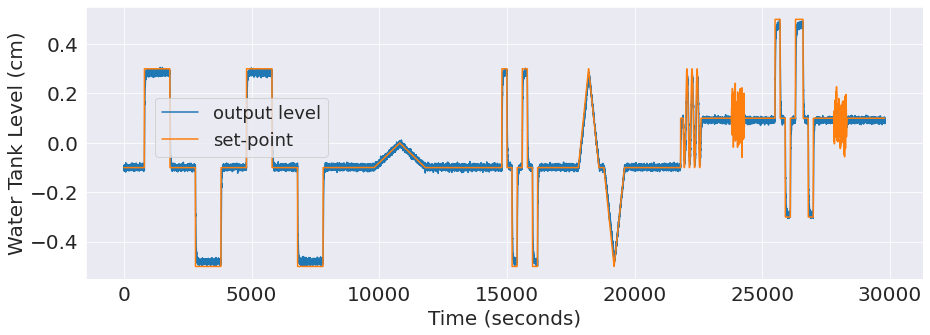

In [ ]:

plt.figure(figsize=(15,5))
plt.plot(Y_clean,label="output level");
plt.plot(X_clean[:,1],label="set-point");
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);
plt.ylabel("Water Tank Level (cm)", fontsize=20);
plt.xlabel("Time (seconds)", fontsize=20);
plt.legend(fontsize=18,bbox_to_anchor=(0.3,0.7));

## **3. Change-point Detection**

In [ ]:
PM = PettittMethod(alpha=0.05,
                   min_length_to_split=1200,
                   verbose=1,
                   n_jobs=1)

In [ ]:
start = time()
pm_initial_segments = PM.fit(X=df[['SP']],
                             y=df[['Y']])
end = time()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: SP
Change-points: []


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   43.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: SP
Change-points: [21801]


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   34.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: SP
Change-points: [1800, 21801, 26800]


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   19.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: SP
Change-points: [800, 1800, 9801, 21801, 26300, 26800, 27000]


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   13.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: SP
Change-points: [800, 1800, 3800, 9801, 11800, 21801, 25900, 26300, 26800, 27000, 28385]


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: SP
Change-points: [800, 1800, 2800, 3800, 6800, 9801, 10301, 11800, 18600, 21801, 25500, 25900, 26300, 26800, 27000, 27922, 28385]


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: SP
Change-points: [800, 1800, 2800, 3800, 4800, 6800, 7800, 9801, 10301, 11175, 11800, 17801, 18600, 19600, 21801, 22001, 25500, 25900, 26300, 26800, 27000, 27922, 28385]


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: SP
Change-points: [800, 1800, 2800, 3800, 4800, 5800, 6800, 7800, 9801, 10301, 11175, 11800, 15000, 17801, 18600, 19600, 21801, 22001, 22501, 25500, 25900, 26300, 26800, 27000, 27922, 28385]


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: SP
Change-points: [800, 1800, 2800, 3800, 4800, 5800, 6800, 7800, 9801, 10301, 11175, 11800, 14800, 15000, 15400, 17801, 18600, 19600, 21801, 22001, 22501, 22600, 25500, 25900, 26300, 26800, 27000, 27922, 28385]


[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: SP
Change-points: [800, 1800, 2800, 3800, 4800, 5800, 6800, 7800, 9801, 10301, 11175, 11800, 14800, 15000, 15400, 16000, 17801, 18600, 19600, 21801, 22001, 22501, 22600, 25500, 25900, 26300, 26800, 27000, 27922, 28385]


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: SP
Change-points: [800, 1800, 2800, 3800, 4800, 5800, 6800, 7800, 9801, 10301, 11175, 11800, 14800, 15000, 15400, 16000, 16200, 17801, 18600, 19600, 21801, 22001, 22501, 22600, 25500, 25900, 26300, 26800, 27000, 27922, 28385]


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: Y
Change-points: []


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: Y
Change-points: [21804]


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: Y
Change-points: [1886, 21804, 26769]


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   18.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: Y
Change-points: [852, 1886, 9816, 21804, 26289, 26769, 28369]


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   13.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: Y
Change-points: [852, 1886, 3878, 9816, 11782, 21804, 25899, 26289, 26769, 27078, 28369]


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    7.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: Y
Change-points: [852, 1886, 2815, 3878, 5921, 9816, 10331, 11782, 18678, 21804, 24231, 25899, 26289, 26769, 27078, 27935, 28369]


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    4.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: Y
Change-points: [852, 1886, 2815, 3878, 4805, 5921, 7877, 9816, 10331, 11186, 11782, 17796, 18678, 19617, 21804, 22675, 24231, 25492, 25899, 26289, 26769, 27078, 27935, 28369]


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: Y
Change-points: [852, 1886, 2815, 3878, 4805, 5921, 6827, 7877, 9816, 10331, 11186, 11782, 15960, 17796, 18678, 19617, 21804, 22675, 23956, 24231, 25492, 25899, 26289, 26769, 27078, 27935, 28369]


[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: Y
Change-points: [852, 1886, 2815, 3878, 4805, 5921, 6827, 7877, 9816, 10331, 11186, 11782, 15565, 15960, 16282, 17796, 18678, 19617, 21804, 22675, 23759, 23956, 24231, 25492, 25899, 26289, 26769, 27078, 27935, 28369]


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Signal: Y
Change-points: [852, 1886, 2815, 3878, 4805, 5921, 6827, 7877, 9816, 10331, 11186, 11782, 15099, 15565, 15960, 16282, 17796, 18678, 19617, 21804, 22675, 23759, 23956, 24231, 25492, 25899, 26289, 26769, 27078, 27935, 28369]
Signal: Y
Change-points: [852, 1886, 2815, 3878, 4805, 5921, 6827, 7877, 9816, 10331, 11186, 11782, 14802, 15099, 15565, 15960, 16282, 17796, 18678, 19617, 21804, 22675, 23759, 23956, 24231, 25492, 25899, 26289, 26769, 27078, 27935, 28369]


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    2.2s finished


In [ ]:
print("Execution Time: {}".format(end-start))

Execution Time: 415.4288058280945


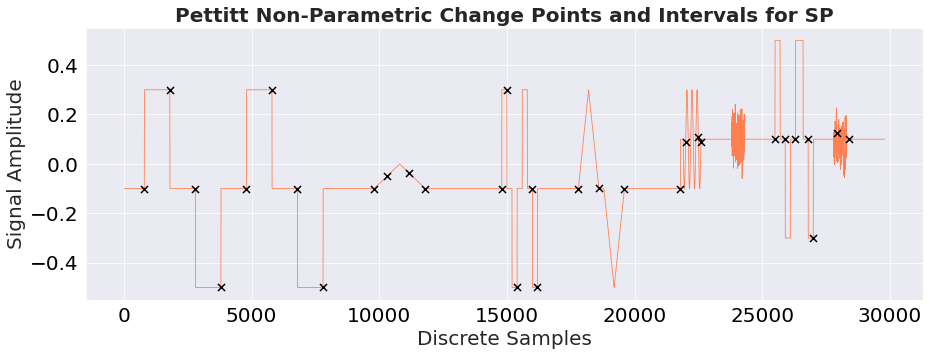

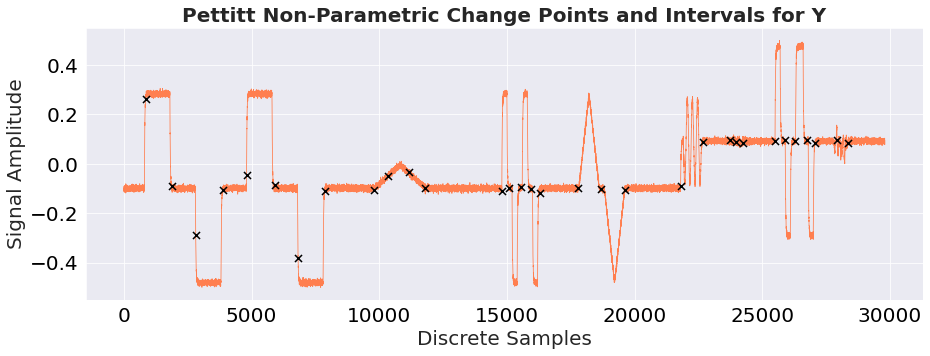

In [ ]:
PM.plot_change_points(X=df[['SP']],y=df[['Y']])